In [2]:
import jax.numpy as jnp
import jax
from numpyro.infer import NUTS, MCMC
import matplotlib.pyplot as plt
import seaborn as sns

from experiments.targets import BLR
from projection_vi.iterative_gaussianization import iterative_gaussianization, iterative_forward_map, apply_householder_transpose

In [3]:
# set up target distribution
n = 20
d = 10

key = jax.random.key(2025)
cov_X = jnp.logspace(-1, 1, d)
key, subkey = jax.random.split(key)
U_ = jnp.linalg.qr(jax.random.normal(subkey, shape=(d, d)))[0]
cov_X = U_ @ jnp.diag(cov_X) @ U_.T
key, subkey = jax.random.split(key)
X = jax.random.multivariate_normal(subkey, mean=jnp.zeros(d), cov=cov_X, shape=(n,))

key, subkey = jax.random.split(key)
y = jax.random.bernoulli(subkey, shape=(n, ))

prior_scale = 2.

target = BLR(X, y, prior_scale=prior_scale)

## Run MCMC

In [4]:
num_warmup = 1000
num_samples = 2000
num_chains = 1
thinning = 2

nuts_kernel = NUTS(target.numpyro_model)
mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples*5, num_chains=num_chains, thinning=5)
mcmc.run(jax.random.key(0))

mcmc_samples = mcmc.get_samples()

param_names = target.param_unc_names()
samples_unc = None
for key in param_names:
    sample = mcmc_samples[key]
    if sample.ndim == 1:
        sample = sample.reshape(-1, 1)
    if samples_unc is None:
        samples_unc = sample
    else:
        samples_unc = jnp.concatenate([samples_unc, sample], axis=1)

mcmc_samples = target.param_constrain(samples_unc)
mcmc_samples = mcmc_samples.reshape(-1, d)

sample: 100%|██████████| 11000/11000 [00:04<00:00, 2690.53it/s, 15 steps of size 2.35e-01. acc. prob=0.92]


In [ ]:
# import pandas as pd
# pd.DataFrame(mcmc_samples).to_csv("experiments/logistic/bayesian_logistic_reference_samples_unc.csv")

In [5]:
mcmc_samples_cov = jnp.cov(mcmc_samples.T)
eigvals, eigvecs = jnp.linalg.eigh(mcmc_samples_cov)
eigvals = eigvals[::-1]
eigvecs = eigvecs[:, ::-1]
print(jnp.cumsum(eigvals) / jnp.sum(eigvals))

[0.29768136 0.5342276  0.7143738  0.8055889  0.8887614  0.9219881
 0.95312184 0.9812163  0.9942036  1.        ]


## Initialize with Laplace approximation

In [6]:
from jax.scipy.optimize import minimize
from scipy.stats import norm

def neg_logp_fn(x):
    return -target.log_prob(x)

bfgs_res = minimize(neg_logp_fn, jnp.zeros(d), method='BFGS', options={'maxiter': 1000})
laplace_mean = bfgs_res.x
laplace_cov = bfgs_res.hess_inv
laplace_scale = jnp.sqrt(jnp.maximum(jnp.diag(laplace_cov), .001))

scale = laplace_scale
shift = laplace_mean

@jax.jit
def logp_fn_shifted(x):
    return target.log_prob(x * scale + shift) + jnp.sum(jnp.log(scale))

In [7]:
def fit(logp_fn, seed=0, nsample=2000, ntrain=1000, gamma=0.95, random_rotate=False, niter=1, beta_0=1., learning_rate=0.1, num_bins=10, range_max=8., max_iter=100):
    key, subkey = jax.random.split(jax.random.key(seed))
    flow, transforms = iterative_gaussianization(logp_fn, 
                                                d, 
                                                nsample=ntrain, 
                                                key=subkey, 
                                                gamma=gamma, 
                                                random_rotate=random_rotate,
                                                niter=niter, 
                                                opt_params={'beta_0': beta_0, 'learning_rate': learning_rate, 'max_iter': max_iter},
                                                flow_params={'num_bins': num_bins, 'range_min': -range_max, 'range_max': range_max, 'boundary_slopes': 'unconstrained'})
    
    key, subkey = jax.random.split(key)
    base_samples = jax.random.normal(subkey, (nsample, d))
    
    transformed_samples, logdet = iterative_forward_map(flow, transforms, base_samples)
    transformed_samples = transformed_samples * scale + shift

    return transformed_samples, transforms[0][0]

In [8]:
def make_histogram(samples):
    _, ax = plt.subplots(1, min(d, 10), figsize=(2*min(d, 10), 2))
    for j in range(min(d, 10)):
        ax[j].hist(mcmc_samples @ eigvecs[:, j], 30, density=True, alpha=.5)
        ax[j].hist(samples @ eigvecs[:, j], 30, density=True, alpha=.5)

### MFVI

In [9]:
seed = 0
mfvi_samples, mfvi_W = fit(logp_fn_shifted, seed, gamma=0.)

Iteration 1/1


Running for 100 iterations: 100%|██████████| 100/100 [00:00<00:00, 430.72it/s]


Loss 24.049028


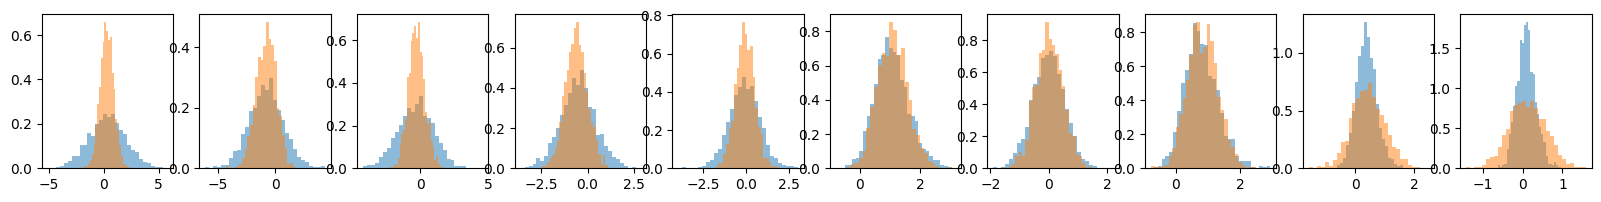

In [10]:
make_histogram(mfvi_samples)

### Rotation by PCA

In [11]:
pca_samples, pca_W = fit(logp_fn_shifted, seed, gamma=0.99)

Iteration 1/1
rank 5


Running for 100 iterations: 100%|██████████| 100/100 [00:00<00:00, 435.78it/s]


Loss 21.289207


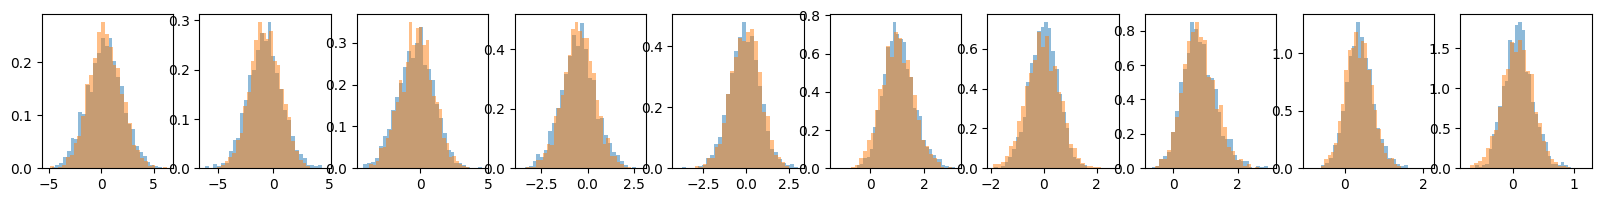

In [12]:
make_histogram(pca_samples)

## Random rotation

In [13]:
random_samples, random_W = fit(logp_fn_shifted, seed, random_rotate=True)

Iteration 1/1


Running for 100 iterations: 100%|██████████| 100/100 [00:00<00:00, 429.38it/s]

Loss 23.332928


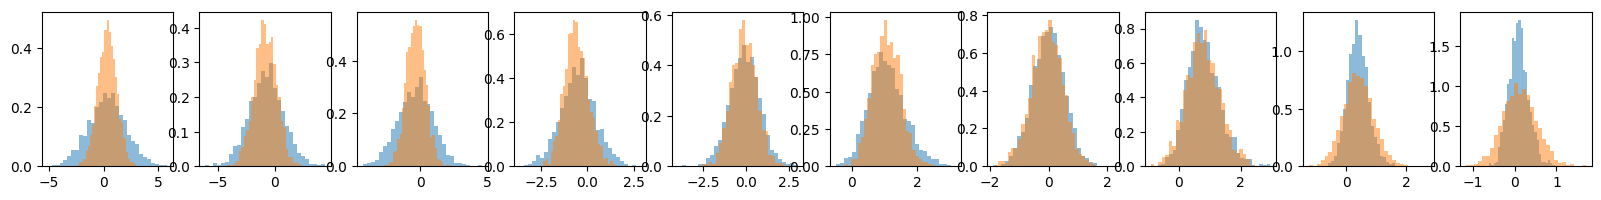

In [14]:
make_histogram(random_samples)

In [15]:
def make_scatter_plot(ax, samples):
    ax.scatter(mcmc_samples[:, 0], mcmc_samples[:, 2], marker='o', alpha=0.4, label='Target', c='deepskyblue')
    ax.scatter(samples[:, 0], samples[:, 2], marker='v', alpha=0.5, label='Samples', c='crimson')

def add_arrow(ax, W=None):
    head_width = 0.2
    head_length = 0.2
    fc = 'white'
    ec = 'white'
    if W is None:
        ax.arrow(0, 0, 1, 0, head_width=head_width, head_length=head_length, fc=fc, ec=ec)
        ax.arrow(0, 0, 0, 1, head_width=head_width, head_length=head_length, fc=fc, ec=ec)
    else:
        for j in range(2):
            theta = apply_householder_transpose(W, jnp.eye(d)[j])
            theta = theta[jnp.array([0, 2])]
            theta /= jnp.linalg.norm(theta)
            ax.arrow(0, 0, theta[0], theta[1], head_width=head_width, head_length=head_length, fc=fc, ec=ec)

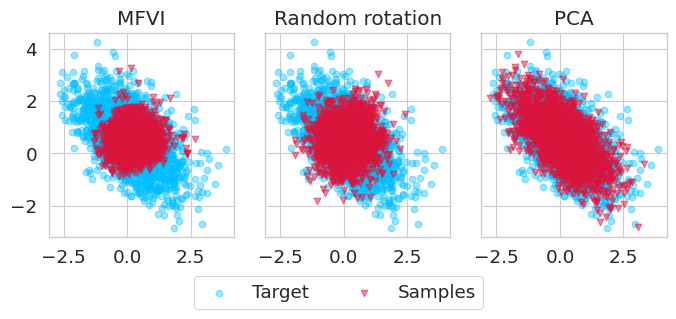

In [18]:
sns.set_theme(context='paper', style='whitegrid', font_scale=1.5)

fig, ax = plt.subplots(1, 3, figsize=(7, 3), sharex=True, sharey=True)
make_scatter_plot(ax[0], mfvi_samples)
make_scatter_plot(ax[1], random_samples)
make_scatter_plot(ax[2], pca_samples)

ax[0].set_title('MFVI')
ax[1].set_title('Random rotation')
ax[2].set_title('PCA')

# add_arrow(ax[0], None)
# add_arrow(ax[1], random_W)
# add_arrow(ax[2], pca_W)

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()

plt.savefig("experiments/logistic/logistic_scatter.pdf", bbox_inches='tight')